In [6]:
import sys
import yaml
import torch
import torchvision
from tqdm import tqdm
from warp_core.utils import load_or_fail

sys.path.append("..")
from utils import *
from train import ControlNetCore, WurstCoreB

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
# SETUP STAGE C
# config_file = '../configs/inference/controlnet_c_3b_identity.yaml'
config_file = '../configs/inference/controlnet_c_3b_canny.yaml'
with open(config_file, "r", encoding="utf-8") as file:
    loaded_config = yaml.safe_load(file)

core = ControlNetCore(config_dict=loaded_config, device=device, training=False)

# SETUP STAGE B
config_file_b = '../configs/inference/stage_b_3b.yaml'
with open(config_file_b, "r", encoding="utf-8") as file:
    config_file_b = yaml.safe_load(file)
    
core_b = WurstCoreB(config_dict=config_file_b, device=device, training=False)

['model_version', 'effnet_checkpoint_path', 'previewer_checkpoint_path', 'controlnet_blocks', 'controlnet_filter']
['model_version', 'stage_a_checkpoint_path', 'effnet_checkpoint_path']


In [3]:
# SETUP MODELS & DATA
extras = core.setup_extras_pre()
models = core.setup_models(extras)
models.generator.bfloat16().eval().requires_grad_(False)
print("CONTROLNET READY")

extras_b = core_b.setup_extras_pre()
models_b = core_b.setup_models(extras_b)
models_b.generator.bfloat16().eval().requires_grad_(False)
print("STAGE B READY")

['transforms', 'clip_preprocess', 'gdf', 'sampling_configs', 'effnet_preprocess', 'controlnet_filter']
Starting Init Model
32.0674946308136
Starting Loading Checkpoint
4.979625940322876


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

['tokenizer', 'text_model', 'generator', 'effnet', 'previewer', 'controlnet']
CONTROLNET READY
['transforms', 'clip_preprocess', 'gdf', 'sampling_configs', 'effnet_preprocess']
Starting Loading Checkpoint for Stage B
1.3301117420196533
1.3313841819763184


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

['tokenizer', 'text_model', 'generator', 'effnet', 'stage_a']
STAGE B READY


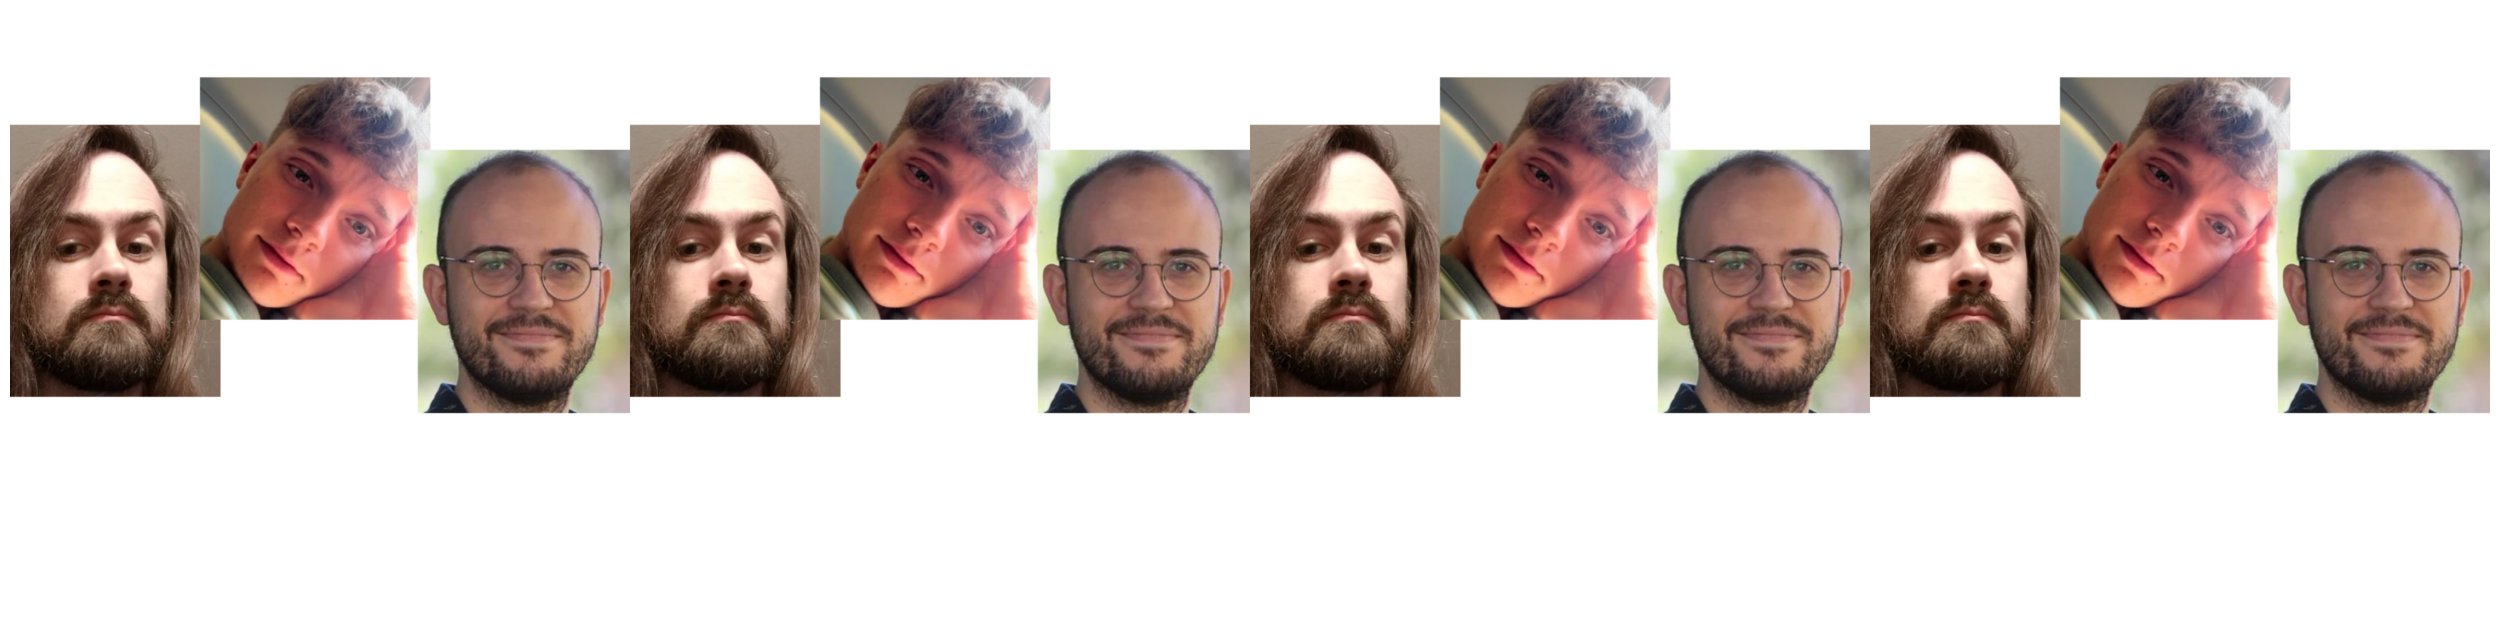

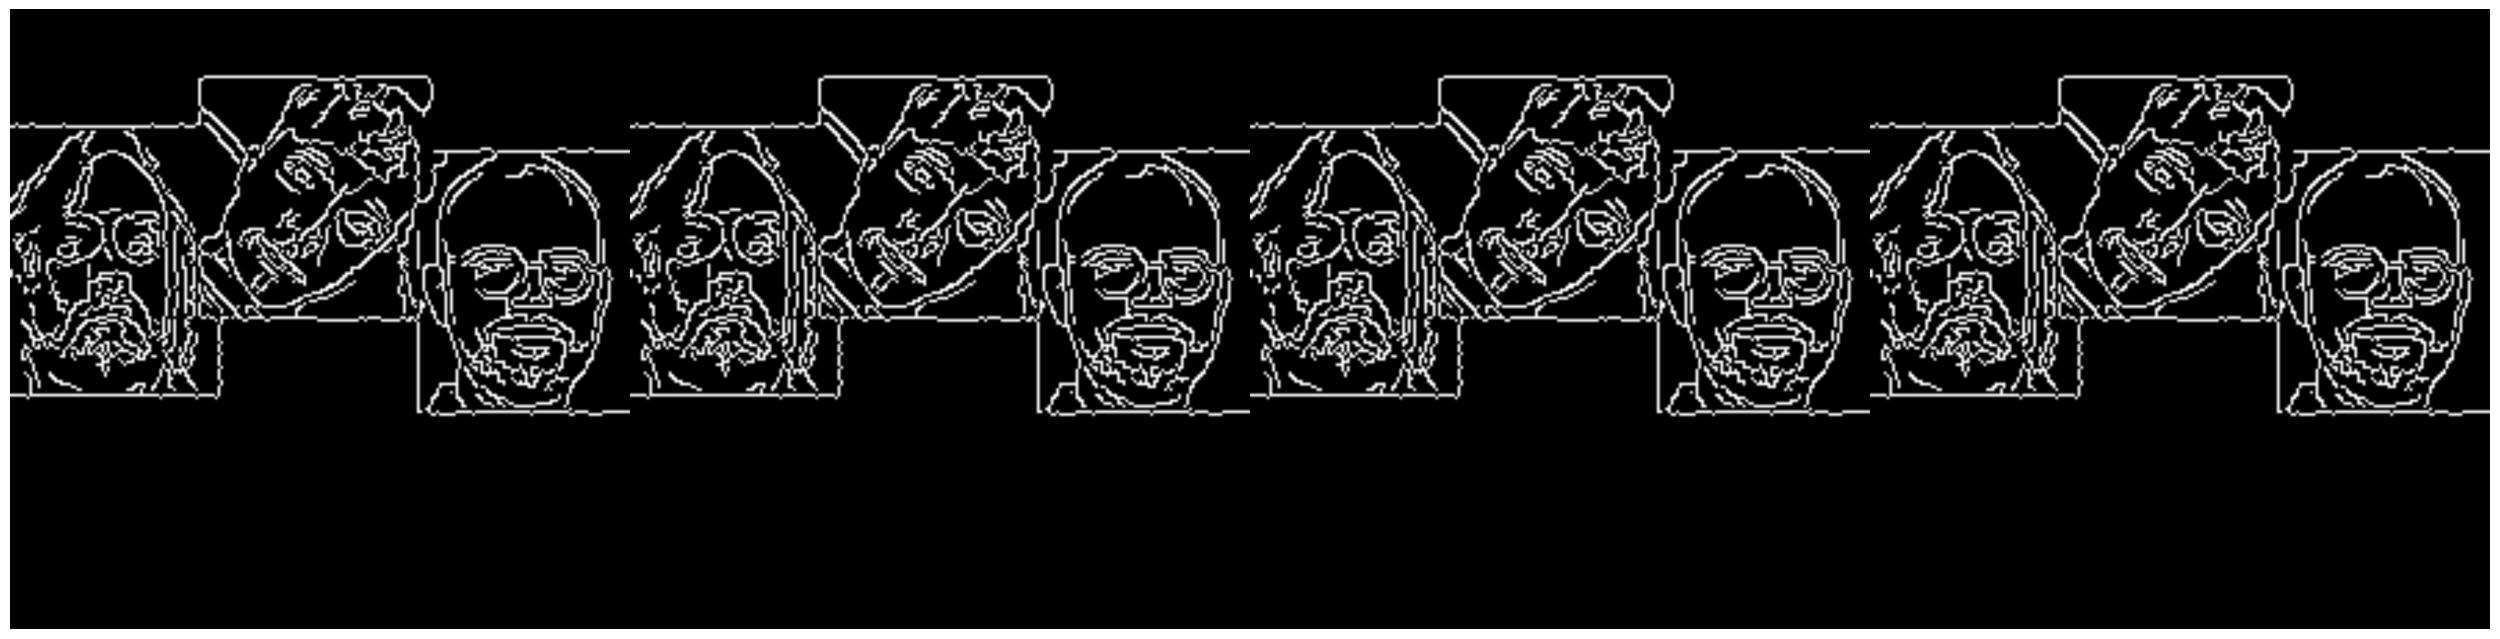

In [8]:
batch_size = 4
cnet_override = None
url = "https://cdn.discordapp.com/attachments/1039261364935462942/1200109692978999317/three_people.png?ex=65c4fc3f&is=65b2873f&hm=064a8cebea5560b74e7088be9d1399a5fe48863d1581e65ea9d6734725f4c8d3&" # Model Wranglers
images = transforms(download_image(url)).unsqueeze(0).expand(batch_size, -1, -1, -1).to(device)

batch = {'images': images.cpu()}

with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.bfloat16):
    cnet, cnet_input = core.get_cnet(batch, models, extras)
    cnet_uncond = core.get_cnet({'images': torch.zeros_like(batch['images'])}, models, extras)[0]
    
# cnet_input = 1-images.mean(dim=1, keepdim=True).cpu().expand(-1, 3, -1, -1)

show_images(batch['images'])
show_images(cnet_input)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.02it/s]


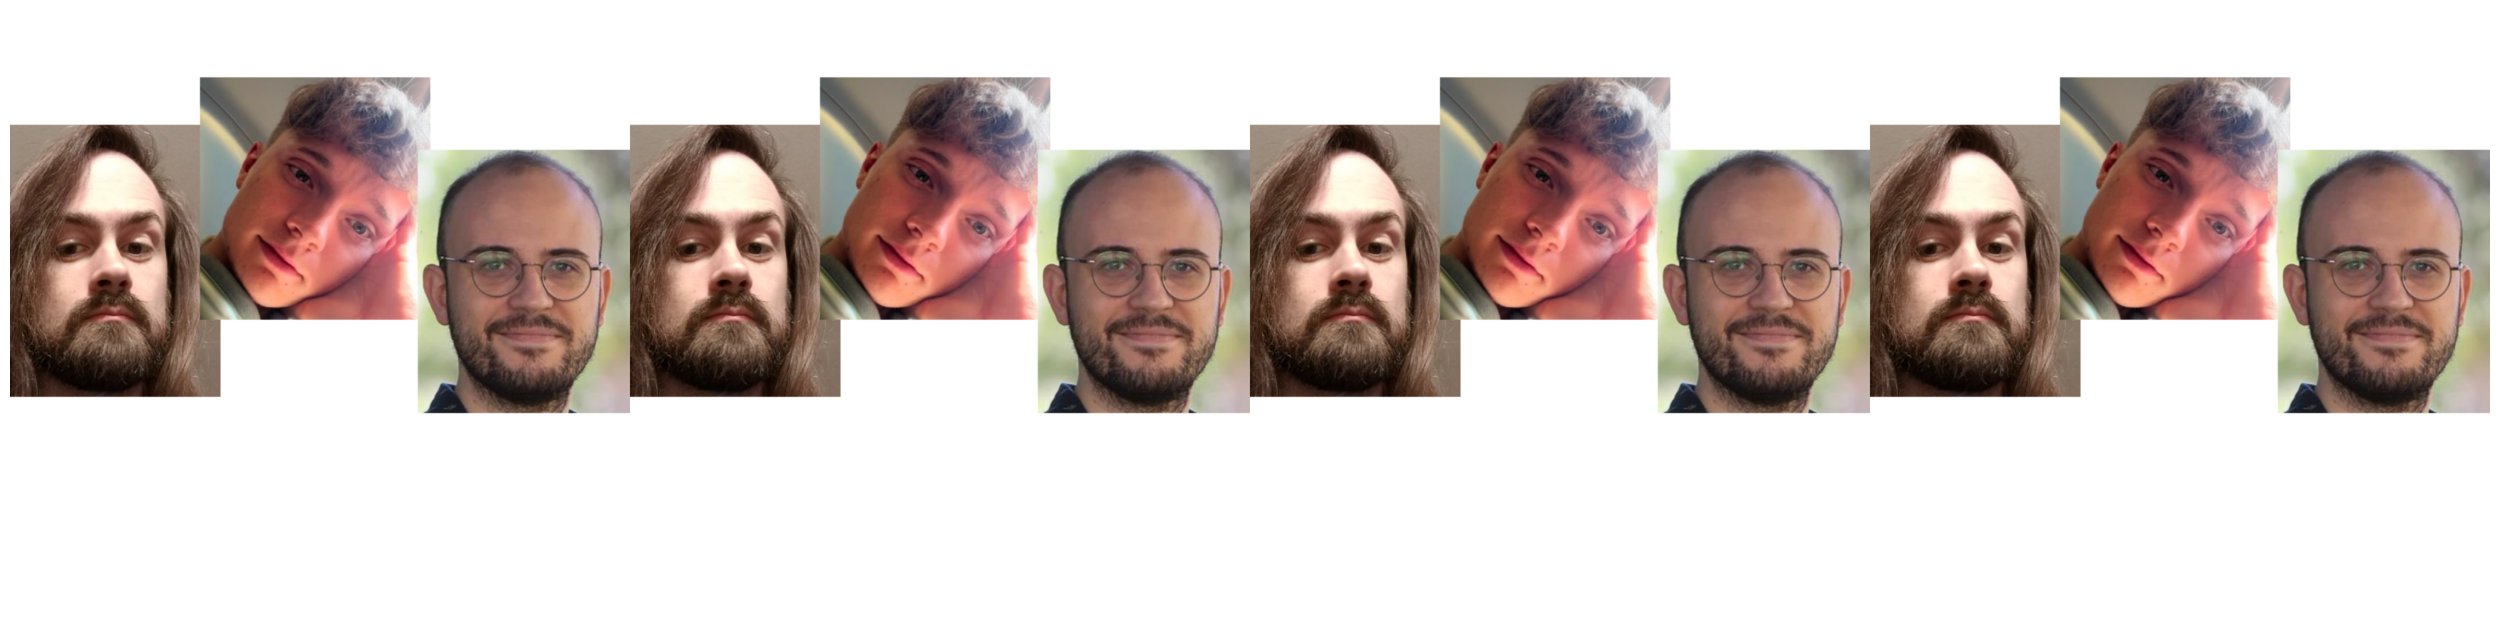

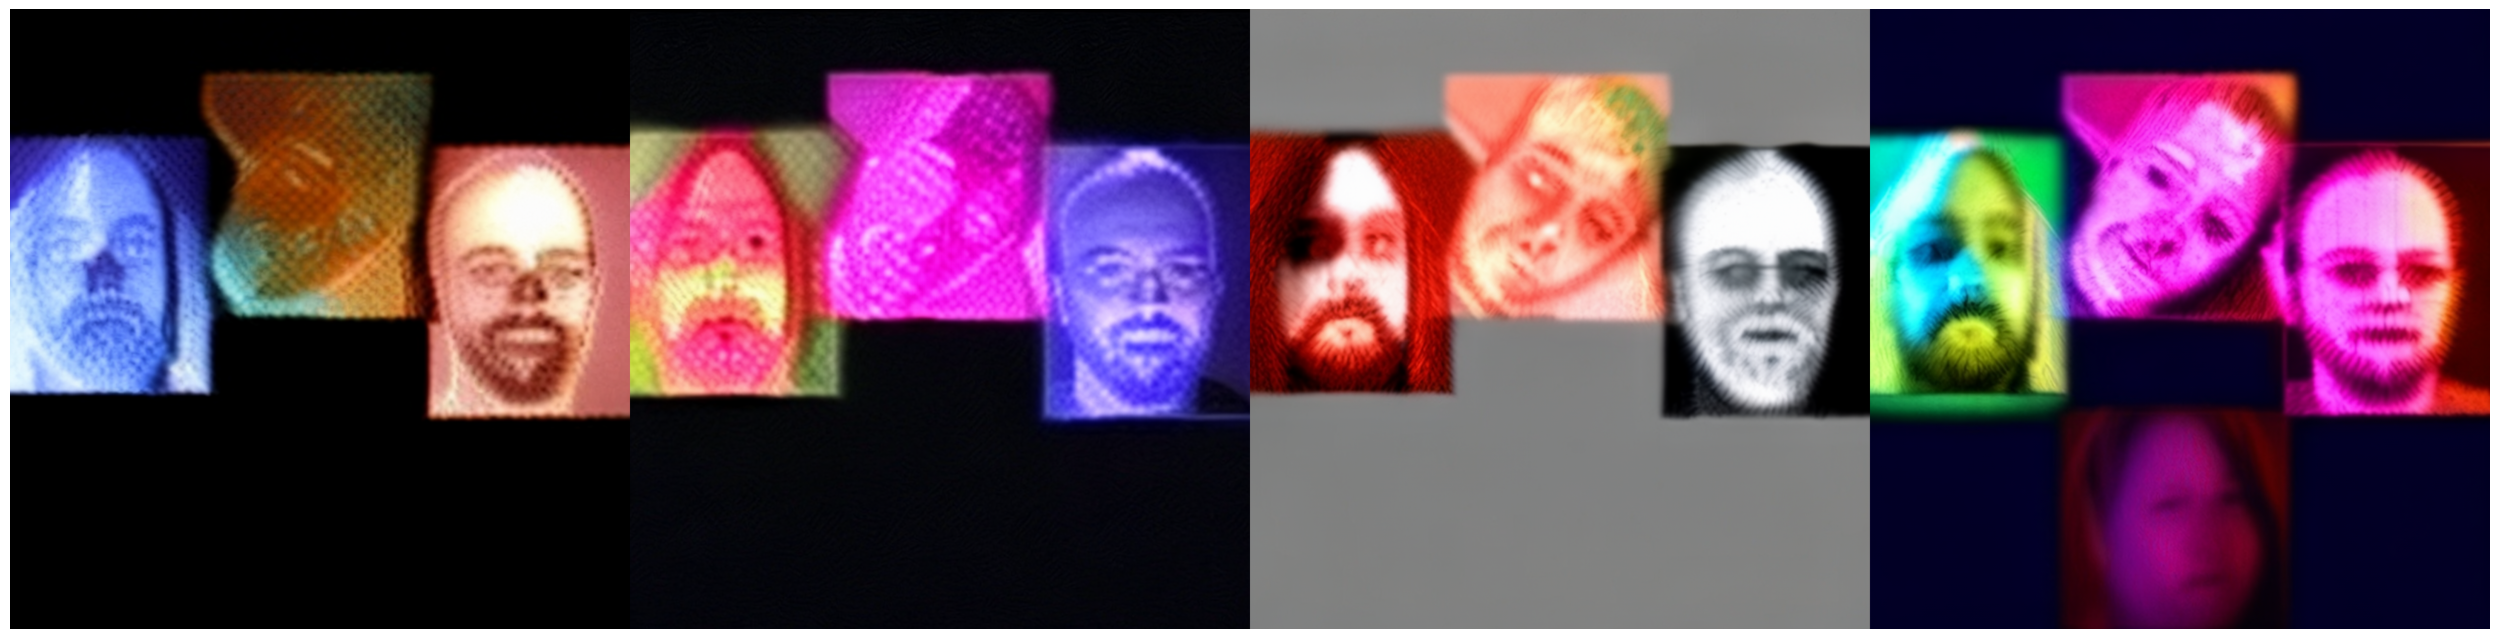

In [10]:
caption = "three dragons"
cnet_multiplier = 1.0 # 0.8 # 0.3

# Stage C Parameters
extras.sampling_configs['cfg'] = 4
extras.sampling_configs['shift'] = 2
extras.sampling_configs['timesteps'] = 20
extras.sampling_configs['t_start'] = 1.0

# Stage B Parameters
extras_b.sampling_configs['cfg'] = 1.1
extras_b.sampling_configs['shift'] = 1
extras_b.sampling_configs['timesteps'] = 10
extras_b.sampling_configs['t_start'] = 1.0

# PREPARE CONDITIONS
batch['captions'] = [caption] * batch_size
conditions = core.get_conditions(batch, models, extras, is_eval=True, is_unconditional=False, eval_image_embeds=False)
unconditions = core.get_conditions(batch, models, extras, is_eval=True, is_unconditional=True, eval_image_embeds=False)    
conditions['cnet'] = [c.clone() * cnet_multiplier if c is not None else c for c in cnet]
unconditions['cnet'] = [c.clone() * cnet_multiplier if c is not None else c for c in cnet_uncond]
conditions_b = core_b.get_conditions(batch, models_b, extras_b, is_eval=True, is_unconditional=False, eval_image_embeds=False)
unconditions_b = core_b.get_conditions(batch, models_b, extras_b, is_eval=True, is_unconditional=True, eval_image_embeds=False)

with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.bfloat16):
    # torch.manual_seed(42)

    sampling_c = extras.gdf.sample(
        models.generator, conditions, (4, 16, 24, 24), # (4, 16, 24, 24),
        unconditions, device=device, **extras.sampling_configs,
    )
    for (sampled_c, _, _) in tqdm(sampling_c, total=extras.sampling_configs['timesteps']):
        sampled_c = sampled_c
        
    # preview_c = models.previewer(sampled_c).float()
    # show_images(preview_c)

    conditions_b['effnet'] = sampled_c
    unconditions_b['effnet'] = torch.zeros_like(sampled_c)

    sampling_b = extras_b.gdf.sample(
        models_b.generator, conditions_b, (4, 4, 256, 256), # (4, 4, 256, 256),
        unconditions_b, device=device, **extras_b.sampling_configs
    )
    for (sampled_b, _, _) in tqdm(sampling_b, total=extras_b.sampling_configs['timesteps']):
        sampled_b = sampled_b
    sampled_b = models_b.stage_a.decode(sampled_b).float()

show_images(batch['images'])
show_images(sampled_b)